<a href="https://colab.research.google.com/github/victorsergio/RIIAA-2018-Higgs-classifier-Sklearn-summer-school/blob/master/RIIAA_2018_clasificaci%C3%B3n_bos%C3%B3n_de_Higgs_Sklearn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Cargar librerias**

In [0]:
%matplotlib inline
%config InlineBackend.figure_format='retina'
import matplotlib
import matplotlib.pyplot as plt

import numpy as np
import scipy as sc
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
import os
from IPython.display import display
import sys

**Metricas**

In [0]:
from sklearn.metrics import roc_curve, auc
import sklearn as sk

    
def AMSScore(s,b): 
    return np.sqrt (2.*( (s + b + 10.)*np.log(1.+s/(b+10.))-s))

def eval_model(Y_true_train,Y_pred_train,w_train,Y_true_test,Y_pred_test,w_test):
    ratio =  float(len(X_train)) /float(len(X_test))
    TruePositive_train = w_train*(Y_true_train==1.0)*(1.0/ratio)
    TrueNegative_train = w_train*(Y_true_train==0.0)*(1.0/ratio)
    TruePositive_valid = w_test*(Y_true_test==1.0)*(1.0/(1-ratio))
    TrueNegative_valid = w_test*(Y_true_test==0.0)*(1.0/(1-ratio))
    s_train = sum ( TruePositive_train*(Y_pred_train==1.0) )
    b_train = sum ( TrueNegative_train*(Y_pred_train==1.0) )
    s_test = sum ( TruePositive_valid*(Y_pred_test==1.0) )
    b_test = sum ( TrueNegative_valid*(Y_pred_test==1.0) )
    score_train = AMSScore(s_train,b_train)
    score_test = AMSScore(s_test,b_test)
    print('--- Resultados --')
    print('- AUC train: {:.3f} '.format(sk.metrics.roc_auc_score(Y_train,Y_train_pred)))
    print('- AUC test : {:.3f} '.format(sk.metrics.roc_auc_score(Y_test,Y_test_pred)))
    print('- AMS train: {:.3f} sigma'.format(score_train))
    print('- AMS test : {:.3f} sigma'.format(score_test))
    return score_train, score_test

def plot_roc(clf,Y_test,Y_test_prob):
    fpr, tpr, thresholds = roc_curve(Y_test, Y_test_prob)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=1, alpha=0.3, label=str(clf.__class__.__name__))
    plt.plot(np.linspace(0,1,100),np.linspace(0,1,100), lw=2, alpha=0.3, label='Suerte')
    plt.legend(loc='lower right')
    plt.xlim([0,1])
    plt.ylim([0,1])
    plt.tight_layout()
    return

**Datos**

In [3]:
!wget https://raw.githubusercontent.com/beangoben/RIIAA_Escuela18/master/datos/training.csv

df=pd.read_csv('training.csv')
print(df.shape)
df.head(1)

--2019-08-05 14:55:02--  https://raw.githubusercontent.com/beangoben/RIIAA_Escuela18/master/datos/training.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 55253673 (53M) [text/plain]
Saving to: ‘training.csv.3’

training.csv.3      100%[===================>]  52.69M   191MB/s    in 0.3s    

2019-08-05 14:55:03 (191 MB/s) - ‘training.csv.3’ saved [55253673/55253673]

(250000, 33)


,EventId,DER_mass_MMC,DER_mass_transverse_met_lep,DER_mass_vis,DER_pt_h,DER_deltaeta_jet_jet,DER_mass_jet_jet,DER_prodeta_jet_jet,DER_deltar_tau_lep,DER_pt_tot,DER_sum_pt,DER_pt_ratio_lep_tau,DER_met_phi_centrality,DER_lep_eta_centrality,PRI_tau_pt,PRI_tau_eta,PRI_tau_phi,PRI_lep_pt,PRI_lep_eta,PRI_lep_phi,PRI_met,PRI_met_phi,PRI_met_sumet,PRI_jet_num,PRI_jet_leading_pt,PRI_jet_leading_eta,PRI_jet_leading_phi,PRI_jet_subleading_pt,PRI_jet_subleading_eta,PRI_jet_subleading_phi,PRI_jet_all_pt,Weight,Label
0,100000,138.47,51.655,97.827,27.98,0.91,124.711,2.666,3.064,41.928,197.76,1.582,1.396,0.2,32.638,1.017,0.381,51.626,2.273,-2.414,16.824,-0.277,258.733,2,67.435,2.15,0.444,46.062,1.24,-2.475,113.497,0.002653,s


**Preprocesamiento para X y Y**

Utilicé random_state para que en la division de los set se seleccionen los elementos de los grupos de forma aleatoria.

In [0]:
Y = df['Label'].replace(to_replace=['s','b'],value=[1,0]).values
weights = df['Weight'].values
X = df.drop(['EventId','Label','Weight'],axis=1).values



In [5]:
from sklearn.model_selection import train_test_split
X_train,X_test,Y_train,Y_test,w_train,w_test = train_test_split(X,Y,weights,random_state=42,train_size=0.3)
print(X_train.shape,Y_train.shape,w_train.shape)
print(X_test.shape,Y_test.shape,w_test.shape)

(75000, 30) (75000,) (75000,)
(175000, 30) (175000,) (175000,)


**ML con SKLearn**

In [6]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingClassifier

f = [('escalar', StandardScaler()),('polinomial', PolynomialFeatures(degree=2)),
    ('modelo', GradientBoostingClassifier(validation_fraction=0.2, n_iter_no_change=5, tol=0.01, n_estimators=1500, learning_rate=0.01,max_depth=10, random_state=0,verbose=1,subsample=0.7))]



pipeline = Pipeline(f)
pipeline.fit(X_train, Y_train)

      Iter       Train Loss      OOB Improve   Remaining Time 
         1           1.2765           0.0091          618.13m
         2           1.2695           0.0088          682.80m
         3           1.2588           0.0086          712.69m
         4           1.2456           0.0085          728.64m
         5           1.2377           0.0083          743.46m
         6           1.2280           0.0082          749.82m
         7           1.2198           0.0081          756.63m
         8           1.2127           0.0077          760.50m
         9           1.2003           0.0075          764.05m
        10           1.1904           0.0075          761.11m
        20           1.1131           0.0062          783.16m
        30           1.0459           0.0051          784.79m
        40           0.9867           0.0043          782.10m
        50           0.9407           0.0037          780.59m
        60           0.8950           0.0031          777.49m
       

Pipeline(memory=None,
         steps=[('escalar',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('polinomial',
                 PolynomialFeatures(degree=2, include_bias=True,
                                    interaction_only=False, order='C')),
                ('modelo',
                 GradientBoostingClassifier(criterion='friedman_mse', init=None,
                                            learning_rate=0.01, loss='deviance',
                                            max_depth=10, max_features=None,
                                            max_leaf_nodes=None,
                                            min_impurity_decrease=0.0,
                                            min_impurity_split=None,
                                            min_samples_leaf=1,
                                            min_samples_split=2,
                                            min_weight_fraction_leaf=0.0,
                               

**Predicciones**

In [0]:
Y_train_pred = pipeline.predict(X_train)
Y_test_pred = pipeline.predict(X_test)
Y_train_prob=pipeline.predict_proba(X_train)[:,1]
Y_test_prob =pipeline.predict_proba(X_test)[:,1]




**Punto de corte**

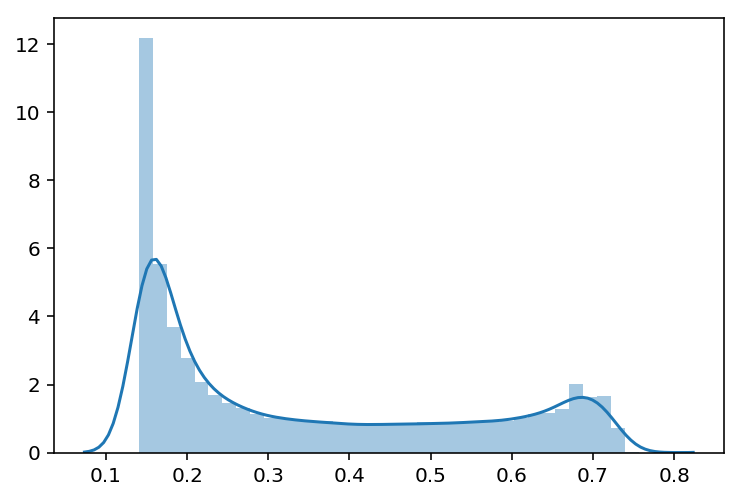

In [8]:
sns.distplot(Y_train_prob)
plt.show()


In [0]:
#pcut = np.percentile(Y_train_prob,85)
#pcut

#Y_train_pred = Y_train_prob > pcut 
#Y_test_pred = Y_test_prob > pcut




In [9]:
eval_model(Y_train,Y_train_pred,w_train,Y_test,Y_test_pred,w_test)

--- Resultados --
- AUC train: 0.824 
- AUC test : 0.781 
- AMS train: 3.239 sigma
- AMS test : 3.326 sigma


(3.2385840364787537, 3.325962006685642)

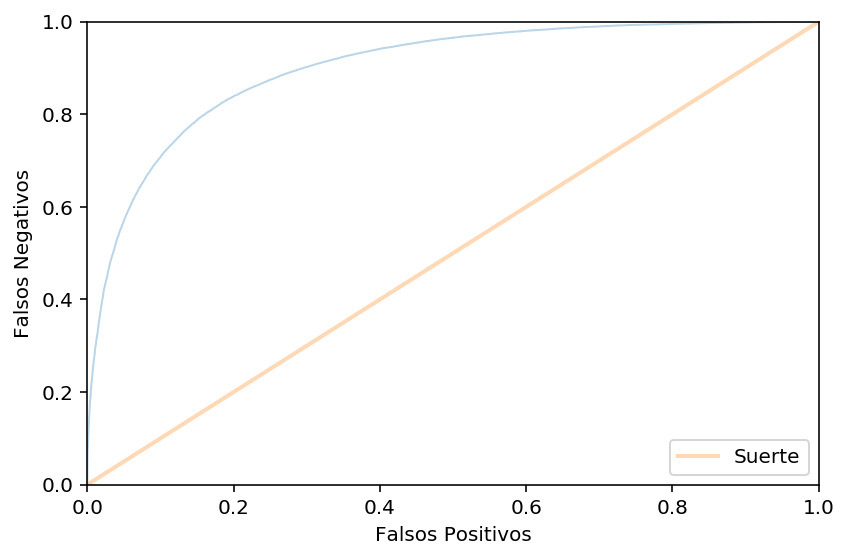

In [10]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve(Y_test, Y_test_prob)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, lw=1, alpha=0.3, label=str(''))
plt.plot(np.linspace(0,1,100),np.linspace(0,1,100), lw=2, alpha=0.3, label='Suerte')
plt.legend(loc='lower right')
plt.xlim([0,1])
plt.ylim([0,1])
plt.xlabel('Falsos Positivos')
plt.ylabel('Falsos Negativos')
plt.tight_layout()
plt.show()